## Notebook : Active learning method comparison and implementation

### Outline

* [Initialization](#init)
* [Feature extraction and prediction](#feat-extract)
* [Core set selection with DBSCAN Clustering](#select-dbscan)
* [Core set selection with KMeans Clustering](#select-kmean)
* [Uncertainty Sampling](#u-sampling)



### Initialization
<a id="init"></a>
Import modules and set data directory


In [1]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import shutil
import pickle
from tqdm import tqdm
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
from matplotlib.patches import Circle
import pandas as pd

# Custom imports
from utils.preprocessing import preprocess_image
from utils.architectures import EffNetB0, CustomUnet
from utils.DCoM import DCoM

# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


c:\Users\Alexandre Bonin\Documents\Stage\active-learning\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
# mode = 'segmentation'
# data_path = r'C:\Users\Alexandre Bonin\Documents\Stage\datasets\Dataset_fixe_2024'
# model_path = r'C:\Users\Alexandre Bonin\Documents\Stage\Code segmentation (Leo)\Models\VL_2024+basemodelproxicam.pt'
# model = CustomUnet(encoder_name="resnet50",
#             encoder_weights="imagenet",
#             classes = 2,
#             activation=None,
#             encoder_depth=5,
#             decoder_channels=[256, 128, 64, 32, 16],
#             extract_features=True
#             ).to(device)

mode = 'classification'
data_path = r'C:\Users\Alexandre Bonin\Documents\Stage\datasets\ProspectFD\test'
model_path = r'models\Run_2024-10-16_14-15-17.pth'
model = EffNetB0(num_classes=2, model_path = model_path, extract_features = True).to(device)

output_dir = os.path.join(data_path + '/DCoM')


if not os.path.exists(output_dir):
    os.makedirs(output_dir, exist_ok=True)

model.eval();


c:\Users\Alexandre Bonin\Documents\Stage\active-learning\utils\architectures.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(self.model_

FileNotFoundError: [Errno 2] No such file or directory: 'models\\Run_2024-10-16_14-15-17.pth'

## Feature extraction and prediction 
<a id="feat-extract"></a>
Extract features from images and make prediction

In [28]:
# Initialize lists to store features and labels
features = []
pseudo_labels = []

features_file = os.path.join(output_dir, 'features.pkl')
pred_file = os.path.join(output_dir, 'pred_df.pkl')
pseudo_labels_file = os.path.join(output_dir, 'pseudo_labels.pkl')

# Iterate over the images in the directory
img_list = [fname for fname in os.listdir(data_path) if fname.endswith(('jpg', 'jpeg', 'png'))]
img_list = [img_name for img_name in img_list[:]]

# # Check if the pickle files exist
# if os.path.exists(features_file) :
#     with open(features_file, 'rb') as f:
#         features = pickle.load(f)

# if os.path.exists(pseudo_labels_file):
#     with open(pseudo_labels_file, 'rb') as f:
#         pseudo_labels = pickle.load(f)

if os.path.exists(pred_file): #Make sure it is the right file
    print("Loading features and predictions from pickle files...")
    # Load the variables from the pickle files
    with open(pred_file, 'rb') as f:
        pred_df = pickle.load(f)
       
else :
    # Initialize a DataFrame to store file paths and prediction probabilities
    pred_df = pd.DataFrame(columns=['img_name', 'pred', 'delta', 'true_label'])
    pred_df['img_name'] = img_list

for img_name in tqdm(img_list):
    file_path = os.path.join(data_path, img_name )

    if os.path.isfile(file_path):
        try:
            # Open and preprocess the image
            img_tensor = preprocess_image(file_path)
            # Make predictions and extract features
            with torch.no_grad():
                pred, feature = model(img_tensor)  # Add batch dimension

            features.append(feature.squeeze(0).cpu().numpy())  # Remove batch dimension and convert to numpy
            pred = torch.softmax(pred, dim=1)

            if mode == 'segmentation' :
              # Get the maximum probabilities and predicted classes
                max_probs, binary = torch.max(pred, dim=1)
                avg_confidence = max_probs.mean().item()

                # Convert tensors to NumPy arrays
                max_probs = max_probs.cpu().numpy()
                binary = binary.cpu().numpy()

                # Calculate the ratio of positive pixels (assuming class 1 is positive)
                positive_pixels = (binary == 1).sum()
                total_pixels = binary.size
                positive_proportion = positive_pixels / total_pixels

                # Store the positive proportion
                pseudo_labels.append(positive_proportion)
                pred_df.loc[pred_df['img_name'] == img_name, 'pred'] = avg_confidence

            elif mode == 'classification' :
                pseudo_labels.append(pred.argmax(dim=1).item())  # Get the predicted class label
                # Create a DataFrame for the current prediction
                pred_df.loc[pred_df['img_name'] == img_name, 'pred'] = pred.max().cpu().numpy()
            
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            # Delete the row with the corresponding file name
            pred_df = pred_df[pred_df['img_name'] != img_name]


# Convert features and labels to numpy arrays
features = np.array(features)
pseudo_labels = np.array(pseudo_labels, dtype=np.float32)
if mode == 'segmentation' :
    bins = [-np.inf, 0.1, 0.3, 0.5, 0.8, np.inf]
    pseudo_labels = pd.cut(pseudo_labels, bins, labels=[0, 1, 2, 3, 4]).astype(int)
    
print(features.shape)



100%|██████████| 77/77 [00:28<00:00,  2.71it/s]


(77, 2458624)


If the size of features is too big, use PCA to reduce dimensions

In [41]:
# Flatten each feature
N = features.shape[0]
features = features.reshape(N, -1)

# Standardize the features
scaler = Normalizer()
features = scaler.fit_transform(features)

# Use randomized solver in PCA for acceleration
if features.shape[1] > 10e5:
    print(f'Old features.shape : {features.shape}')
    pca = PCA(n_components=min(features.shape[0], 1000), svd_solver='randomized')
    features = pca.fit_transform(features)
    print(f'New features.shape : {features.shape}')

Old features.shape : (77, 2458624)
New features.shape : (77, 77)


In [47]:
# Define the new labels for each category
new_labels = [0,1,2]

# Rename the categories
categorical_series = pseudo_labels.rename_categories(new_labels)
pseudo_labels = categorical_series.to_numpy()


## Balanced selection using DCoM algorithm

The DCom method is a state-of-the-art method for active learning (Cf. Paper with code ranking) achieving high performance in both the low and high budget regimes.
<br/>

According to the authors of the algorithm : "*DCoM employs a representation learning approach. Initially, a 
Δavg-radius ball is placed around each point. The Δlist provides a specific radius for each labeled example individually. From these, a subset of b balls is chosen based on their coverage of the most points, with the centers of these balls selected as the samples to be labeled. After training the model, the Δ list is updated according to the purity of the balls to achieve more accurate radii and coverage. DCoM utilizes this coverage to determine the competence score, which balances typicality and uncertainty.*"
<br/> 

The algorithm is based on the paper Mishal, Inbal, et Daphna Weinshall. « DCoM: Active Learning for All Learners ». arXiv, 24 juillet 2024. http://arxiv.org/abs/2407.01804.



### 1. Initialize DCoM 

In [22]:
lSet = pred_df.loc[pred_df['true_label'].notna()].index.tolist()
lSet_labels = pred_df.loc[lSet, 'true_label'].values.tolist()
lSet_deltas = pred_df.loc[lSet, 'delta'].values.tolist()

budgetSize = 6


### 2. Selection
Use the algorithm to select the first set of samples to label : active_set is the set of samples to label, new_uset is the new unlabeled set.  

In [23]:
dcom = DCoM(features, lSet, budgetSize = budgetSize, lSet_deltas=lSet_deltas)
active_set, new_uset, active_deltas = dcom.select_samples(pred_df)
sampled_images = []

# Now use the sampled_indices to get the corresponding image file paths
for i, idx in enumerate(active_set):
    sampled_images.append(pred_df.iloc[int(idx)]['img_name'])
    pred_df.at[int(idx), 'delta'] = active_deltas[i]  #Add active set deltas to relevant indices of pred_df


Max delta is 2.310535774939538
Initial delta is 0.7239142582769349

==================== Start DCoM Active Sampling ====================
Start constructing graph using delta=2.310535774939538
Before delete lSet neighbors: Graph contains 5775 edges.
a = 0.8, k = 50, p = 1.0
Start calculating points margin.
Start constructing graph using delta=2.2899999999999996
Before delete lSet neighbors: Graph contains 5775 edges.
Finished constructing graph using delta=2.2899999999999996
Graph contains 0 edges.
rank shape: (77,), margin shape: 77
a = 0.8, k = 50, p = 1.0
Iteration is 0.	Graph has 0 edges.	Coverage is 1.000. 	Curr choice is 22. 	competence_score=1.0
rank shape: (77,), margin shape: 77
a = 0.8, k = 50, p = 1.0
Iteration is 1.	Graph has 0 edges.	Coverage is 1.000. 	Curr choice is 42. 	competence_score=1.0
rank shape: (77,), margin shape: 77
a = 0.8, k = 50, p = 1.0
Iteration is 2.	Graph has 0 edges.	Coverage is 1.000. 	Curr choice is 43. 	competence_score=1.0
rank shape: (77,), margin 

Display the samples

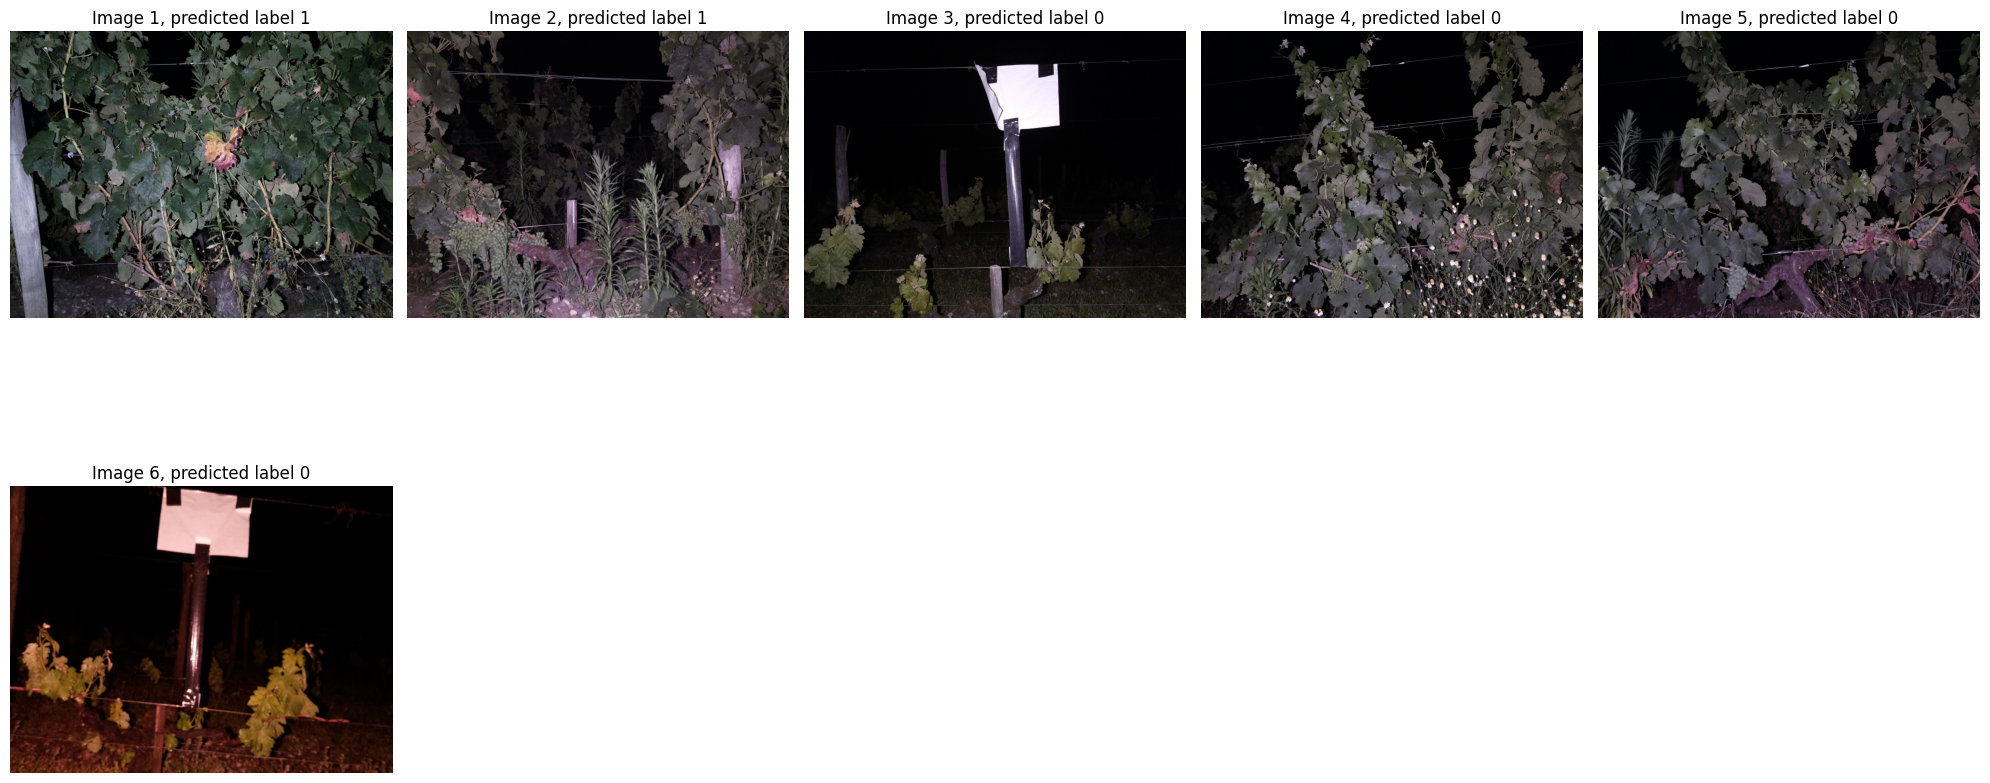

In [24]:

# Determine the number of rows and columns for the grid
num_images = len(sampled_images)
num_cols = 5  # Number of columns
num_rows = (num_images + num_cols - 1) // num_cols  # Calculate the number of rows needed

# Display the images in a grid layout
plt.figure(figsize=(20, 10))
for i, img_name in enumerate(sampled_images):
    img_path = os.path.join(data_path, img_name)
    try:
        img = Image.open(img_path)
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)
        plt.title(f"Image {i+1}, predicted label {pseudo_labels[active_set[i]]}")
        plt.axis('off')
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

plt.tight_layout()
plt.show()



Save the active images (to be labeled) to a subfolder 'DCoM/samples' of the original dataset.

In [25]:
output_subdir = os.path.join(output_dir, 'samples')

if not os.path.exists(output_subdir):
    os.makedirs(output_subdir, exist_ok=True)

print("Sampled image:")
for img_name in sampled_images:
    img = os.path.join(data_path, img_name)
    output_path = os.path.join(output_subdir, img_name)
    shutil.copy(img, output_path)
    print(output_path)

# Define the path to the labels subfolder
labels_folder = os.path.join(output_dir, 'labels')

if not os.path.exists(labels_folder):
    os.makedirs(labels_folder, exist_ok=True)

Sampled image:
C:\Users\Alexandre Bonin\Documents\Stage\datasets\Dataset_fixe_2024/DCoM\samples\v07_colo_0802_0202_292.jpg
C:\Users\Alexandre Bonin\Documents\Stage\datasets\Dataset_fixe_2024/DCoM\samples\v10_v10_colo_0720_0202_279.jpg
C:\Users\Alexandre Bonin\Documents\Stage\datasets\Dataset_fixe_2024/DCoM\samples\v11_colo_0422_0202_191.jpg
C:\Users\Alexandre Bonin\Documents\Stage\datasets\Dataset_fixe_2024/DCoM\samples\v05_colo_0630_0202_259.jpg
C:\Users\Alexandre Bonin\Documents\Stage\datasets\Dataset_fixe_2024/DCoM\samples\v05_colo_0801_0202_291.jpg
C:\Users\Alexandre Bonin\Documents\Stage\datasets\Dataset_fixe_2024/DCoM\samples\v08_colo_0427_0202_195.jpg


### 3. Label and retrain model
You can then label the images , train the model on the new set of images and add the labels to a subfolder of the dataset called 'labels'. Then run the following cells to add the new labels to pred_df:

In [16]:
labels_folder = os.path.join(output_dir, 'labels')

# Ensure only the images in the labeled set have a true label
if 'true_label' in pred_df.columns:
    pred_df['true_label'] = np.nan

# Read image names and labels from the labels subfolder
for root, dirs, files in os.walk(labels_folder):
    for file_name in files:
        image_path = os.path.join(root, file_name)

        if mode == 'classification' and file_name.endswith('.jpg'):
            # Extract the label from the folder name
            parent_dir = os.path.dirname(root)
            folders = sorted(os.listdir(parent_dir))
            folder_index = folders.index(os.path.basename(root))
            label = folder_index
            pred_df.loc[pred_df['img_name'] == file_name, 'true_label'] = label # Update the true_label column for the corresponding filename

        elif mode == 'segmentation' and file_name.endswith('.png'):
            img_name = os.path.splitext(file_name)[0] + '.jpg'
            # Calculate the proportion of white pixels
            image = Image.open(image_path).convert('L')  # Convert to grayscale
            image_array = np.array(image)
            white_pixel_count = np.sum(image_array == 255)
            total_pixel_count = image_array.size
            label = white_pixel_count / total_pixel_count
            pred_df.loc[pred_df['img_name'] == img_name, 'true_label'] = label

if mode == 'segmentation' :
    pred_df['true_label'] = pd.cut(pred_df['true_label'], bins = bins, labels = [i for i in range(len(bins)-1)])

print(pred_df.loc[pred_df['true_label'].notna()])


                      img_name      pred delta true_label
2   v05_colo_0503_0202_201.jpg  0.535082  2.29          0
13  v07_colo_0504_0202_203.jpg  0.534516  2.29          2
22  v08_colo_0429_0202_197.jpg  0.532832  2.29          1
42  v11_colo_0513_0202_212.jpg  0.533513  2.29          2
43  v11_colo_0517_0202_216.jpg  0.534433  2.29          2
74  v14_colo_0804_0202_294.jpg  0.545531  2.29          2


### 4. Update deltas for labeled set
Then update the labeled set and the deltas for the new images

In [17]:

lSet = pred_df.loc[pred_df['true_label'].notna()].index.tolist()

for i in list(set(pred_df.index)): #Ensures only the images in the labeled set have a delta
    if pred_df.at[i, 'true_label'] is np.nan:
        pred_df.at[i, 'delta'] = np.nan

lSet_labels = pred_df.loc[lSet, 'true_label'].values.tolist()
lSet_deltas = pred_df.loc[lSet, 'delta'].values.tolist()

print(f'lSet : {lSet}')
print(f'lSet_labels : {lSet_labels}')
print(f'lSet_deltas : {lSet_deltas}')

dcom = DCoM(features, lSet, budgetSize = budgetSize, lSet_deltas=lSet_deltas)
lSet_deltas[-1 * budgetSize:] = dcom.new_centroids_deltas(lSet_labels, pseudo_labels=pseudo_labels, budget= budgetSize)

# Update the deltas in the pred_df DataFrame
pred_df.loc[lSet, 'delta'] = lSet_deltas


lSet : [2, 13, 22, 42, 43, 74]
lSet_labels : [0, 2, 1, 2, 2, 2]
lSet_deltas : ['2.29', '2.29', '2.29', '2.29', '2.29', '2.29']
Max delta is 2.310535774939538
Initial delta is 0.7239142582769349
Start constructing graph using delta=2.310535774939538
Before delete lSet neighbors: Graph contains 5775 edges.
Start constructing graph using delta=2.310535774939538
Before delete lSet neighbors: Graph contains 5775 edges.
Current threshold:  0.6000000000000001
start calculation for cent_idx: 0
centroid:  2 , idx:  0 . delta =  1.155267887469769  and purity =  0.6623376623376623
centroid:  2 , idx:  0 . delta =  1.7329018312046536  and purity =  0.6623376623376623
centroid:  2 , idx:  0 . delta =  2.021718803072096  and purity =  0.6623376623376623
centroid:  2 , idx:  0 . delta =  2.166127289005817  and purity =  0.6623376623376623
centroid:  2 , idx:  0 . delta =  2.2383315319726775  and purity =  0.6623376623376623
centroid:  2 , idx:  0 . delta =  2.274433653456108  and purity =  0.66233766

### 5. Plot the features

Finally, plot the features. On the graph you can see the features respresented in a 2D embedding. They are colored by their predicted pseudo label. The labeled samples are marked in red and their deltas (a ball of sufficient purity to be represented by the selected sample) are displayed.

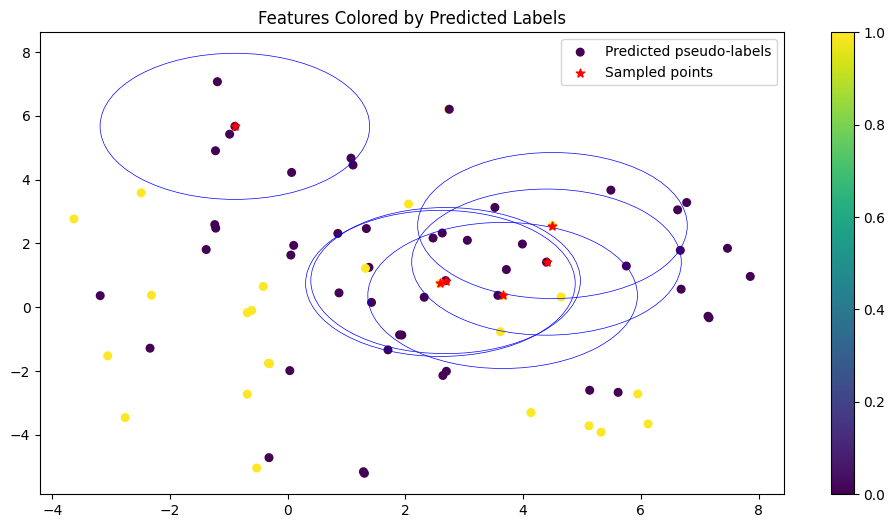

In [20]:
# Visualize the features in 2D using t-SNE
tsne = TSNE(n_components=2, random_state = 42)
features_2d = tsne.fit_transform(features)

# Extract the 2D coordinates for the sampled points
sampled_points_2d = features_2d[lSet]

plt.figure(figsize=(12, 6))
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=pseudo_labels, cmap='viridis', s=30, label = 'Predicted pseudo-labels')
# plt.scatter(sampled_points_2d[:, 0], sampled_points_2d[:, 1], c=pred_df.loc[pred_df['true_label'].notna(),'true_label'], cmap='viridis', s=31)
# Add circles of radius delta around points from lSet
ax = plt.gca()
for i, point_idx in enumerate(lSet):
    point_2d = features_2d[point_idx]
    delta = float(lSet_deltas[i])
    circle = Circle(point_2d, radius=delta, color='blue', fill=False, linestyle='-', linewidth=0.5)
    ax.add_patch(circle)

# Highlight the sampled points in a different color or marker (e.g., red stars)
plt.scatter(sampled_points_2d[:, 0], sampled_points_2d[:, 1], c='red', marker='*', s=40, label='Sampled points')

plt.colorbar()
plt.title("Features Colored by Predicted Labels")

# Add a legend to highlight the sampled points
plt.legend()

plt.show()


### 6. Save data for the next round
Finally, save the pred_df DataFrame to a pickle file in case the notebook is reset betwwen rounds. To select new samples, you can run the 6 steps above again

In [61]:
with open(os.path.join(output_dir,'pred_df.pkl'), 'wb') as f:
    pickle.dump(pred_df, f)

with open(os.path.join(output_dir,'features.pkl'), 'wb') as f:
    pickle.dump(features, f)

with open(os.path.join(output_dir, 'pseudo_labels.pkl'), 'wb') as f:
    pickle.dump(pseudo_labels, f)
